In [1]:
import copy
import os

from jax import config as jax_config
from ml_collections import config_dict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import quimb.tensor as qtn
import quimb.gen as qugen
import seaborn as sns
from tqdm import tqdm
import xarray as xr

from tn_generative import mps_utils
from tn_generative import physical_systems
from tn_generative import plotting_utils
from tn_generative import run_data_generation
from tn_generative import run_training
from tn_generative.train_configs import surface_code_train_config
from tn_generative import train_utils

HOME = os.path.expanduser('~')

## Example: data generation and training for a surface code 

### Data generation

In [79]:
# Create a 3x3 surface code PhysicalSystem
size_x = 3
size_y = 3
surface_code = physical_systems.SurfaceCode(size_x, size_y)
# Get the Hamiltonian of the system as a matrix product operator
task_mpo = surface_code.get_ham() # MPO representation of the Hamiltonian

Text(0.5, 1.0, 'X plaquettes and boundaries')

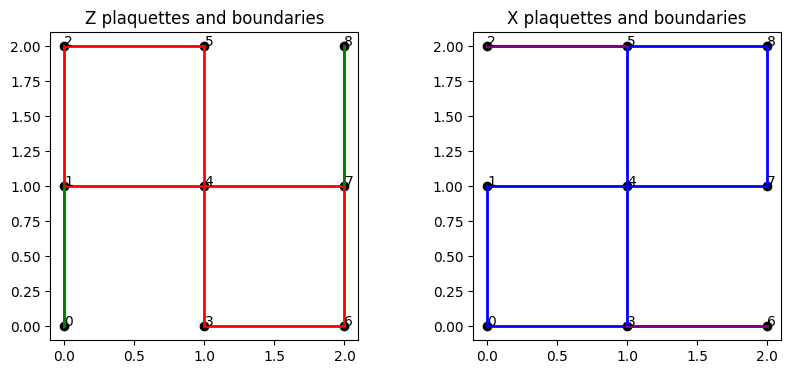

In [91]:
#@title || Visualizing surface code hamiltonian

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
z_plaquettes, x_plaquettes, z_boundaries, x_boundaries = (
    surface_code._get_surface_code_collections())
lattice = z_plaquettes.lattice  # all have the same lattice
plotting_utils.plot_lattice(lattice, ax1, annotate=True)
plotting_utils.plot_lattice(lattice, ax2, annotate=True)
ax1.set_aspect("equal")
ax2.set_aspect("equal")
plotting_utils.plot_loops(z_plaquettes, ax1, c='red')
plotting_utils.plot_loops(x_plaquettes, ax2, c='blue')
plotting_utils.plot_loops(z_boundaries, ax1, c='green')
plotting_utils.plot_loops(x_boundaries, ax2, c='purple')
ax1.set_title("Z plaquettes and boundaries")
ax2.set_title("X plaquettes and boundaries")

In [3]:
#@title Running DMRG
data_config = config_dict.ConfigDict({
    'dtype': np.complex128,
    'dmrg': config_dict.ConfigDict({
        'bond_dims': 10,
        'solve_kwargs': {
          'max_sweeps': 40, 'cutoffs': 1e-6, 'verbosity': 1
        }
    }),
    'backend': 'numpy',
    'contract_backend': 'numpy',
    'tensor_linop_backend': 'numpy',
    'init_seed': 42,
})
qtn.contraction.set_tensor_linop_backend(data_config.backend)
qtn.contraction.set_contract_backend(data_config.contract_backend)
qugen.rand.seed_rand(data_config.init_seed) # set random seed for reproducibility
mps = qtn.MPS_rand_state(task_mpo.L, data_config.dmrg.bond_dims, dtype=data_config.dtype)
dmrg = qtn.DMRG2(task_mpo, bond_dims=data_config.dmrg.bond_dims, p0=mps)
convergence = dmrg.solve(**data_config.dmrg.solve_kwargs)
mps = dmrg.state.copy()
mps = mps.canonize(0)  # right canonicalize MPS.

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-06


100%|#############################################| 8/8 [00:01<00:00,  5.18it/s]

Energy: (-7.9999999998099405+6.064403151364122e-18j) ... not converged.
SWEEP-2, direction=R, max_bond=(4/10), cutoff:1e-06



100%|############################################| 8/8 [00:00<00:00, 580.59it/s]

Energy: (-8.000000000000005+1.7765714764200698e-17j) ... converged!


In [30]:
#@title Data generation

# Generate a dataset of 1000 samples
data_config.update_from_flattened_dict({
    'num_samples': 10000, # number of samples to generate
    'sampling_method': 'x_or_z_basis_sampler', # random XZ basis measurement
})
ds = run_data_generation._run_data_generation(
    data_config.init_seed, data_config.num_samples, data_config.sampling_method,
    mps
)

100%|##########| 10000/10000 [00:01<00:00, 8043.54it/s]


In [31]:
# dataset: measurement basis (random XZ basis)
# 0: X basis, 2: Z basis
ds.basis

<xarray.DataArray 'basis' (sample: 10000, site: 9)>
array([[2, 2, 2, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [2, 2, 0, ..., 2, 0, 2],
       ...,
       [2, 0, 2, ..., 2, 0, 2],
       [0, 2, 2, ..., 0, 2, 2],
       [2, 0, 2, ..., 2, 2, 2]], dtype=int32)
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * site     (site) int64 0 1 2 3 4 5 6 7 8

In [32]:
# dataset measurements outcomes
ds.measurement

<xarray.DataArray 'measurement' (sample: 10000, site: 9)>
array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1]])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * site     (site) int64 0 1 2 3 4 5 6 7 8

In [33]:
# Once we have the dataset in the form of an xarray dataset, we can use it to train our model!
# Save the target state and the dataset
mps_state_ds = mps_utils.mps_to_xarray(mps)
full_ds = xr.merge([mps_state_ds, ds])
# To save the dataset to disk, need to split the complex numbers into real and imaginary parts
# full_ds = data_utils.split_complex_ds(full_ds)

In [34]:
# dataset with target state and measurements
# left_tensor: left tensor A^[0] of the MPS
# bulk_tensors: bulk tensors A^[1] to A^[L-2] of the MPS
# right_tensor: right tensor A^[L-1] of the MPS
# basis: measurement basis (random XZ basis)
# measurement: measurement outcomes
full_ds

<xarray.Dataset>
Dimensions:       (right_ind: 4, phys_ind: 2, bulk_site: 7, left_ind: 4,
                   sample: 10000, site: 9)
Coordinates:
  * left_ind      (left_ind) int64 0 1 2 3
  * right_ind     (right_ind) int64 0 1 2 3
  * phys_ind      (phys_ind) int64 0 1
  * bulk_site     (bulk_site) int64 1 2 3 4 5 6 7
  * sample        (sample) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * site          (site) int64 0 1 2 3 4 5 6 7 8
Data variables:
    left_tensor   (right_ind, phys_ind) complex128 (-0.7071067811865479+1.259...
    bulk_tensor   (bulk_site, left_ind, right_ind, phys_ind) complex128 (0.30...
    right_tensor  (left_ind, phys_ind) complex128 (-1+0j) 0j (-0+0j) ... 0j 0j
    measurement   (sample, site) int64 0 0 0 1 0 0 1 0 0 0 ... 1 0 0 0 1 1 0 1 1
    basis         (sample, site) int32 2 2 2 0 0 2 2 0 0 0 ... 2 0 2 0 2 0 2 2 2

### Run training

In [35]:
#@title MLE training
# Train the model using maximum likelihood estimation
def run_mle(
    train_samples,
    full_ds=full_ds,
    train_steps=200,
    test_samples=1000,
    bond_dim=10,
):
  train_ds = full_ds.sel(sample=slice(0, train_samples-1))
  test_ds = full_ds.sel(sample=slice(full_ds.sample.size - test_samples, None))

  jax_config.update('jax_enable_x64', True)
  qtn.contraction.set_contract_backend('jax')
  train_config = config_dict.ConfigDict()
  train_config.reg_name = 'none' # no regularization
  train_config.kwargs = {} # we can pass additional keyword arguments to the training scheme
  mps = qtn.MPS_rand_state(full_ds.site.size, bond_dim, dtype='complex128')
  return train_utils.TRAIN_SCHEME_REGISTRY['lbfgs'](mps, train_ds, test_ds, train_config, train_steps)


In [38]:
train_df, eval_df, trained_mps = run_mle(8000) # Use 8000 samples for training

+4.901274264059 [best: +4.901274264059] : : 211it [00:05, 41.54it/s]                       


Text(0.5, 1.0, 'Training and Evaluation: fidelity=0.9969')

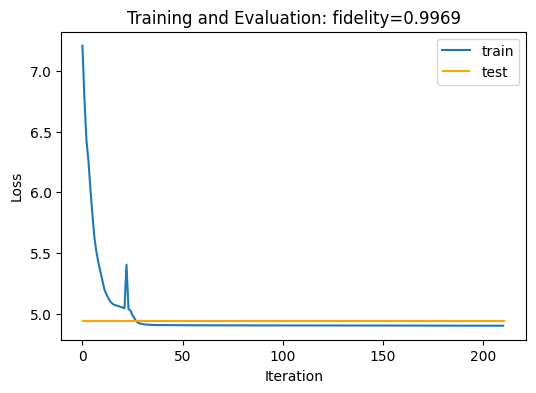

In [39]:
# Visualize training metrics
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_df.loss, label='train')
ax.hlines(eval_df.test_ll, 0, train_df.loss.size, label='test', color='orange')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title(f'Training and Evaluation: fidelity={eval_df.fidelity[0]:.4f}')

## Example: batched training via configs

To run the following cells requires downloading the [datasets](https://doi.org/10.5281/zenodo.11397880) for $3 \times 3$ surface code

In [3]:
all_train_dfs = []
all_eval_dfs = []
all_mps_results = []
for i in tqdm(range(5)): # Run 5 training experiments preset in `batched_configs`. 
  batched_configs = surface_code_train_config.get_config()
  config = copy.deepcopy(batched_configs)
  config.job_id = 0
  config.task_id = i
  config.data.dir = f'{HOME}/tn_shadow_dir/Draft/Results_Dataset/Dataset' # Replace this directory with the directory where you want to load the data
  config.sweep_name = 'sweep_sc_3x3_fn'
  config.training.reg_name = 'none' # no regularization
  config.training.steps_sequence = (10000, 400)
  train_df, eval_df, final_mps = run_training.run_full_batch_experiment(config)
  all_train_dfs.append(train_df)
  all_eval_dfs.append(eval_df)
  all_mps_results.append(final_mps)  

Step: 100%|██████████| 10000/10000 [00:10<00:00, 961.91it/s, loss=4.15449264319179, opt_step=9950]  
+4.150392782944 [best: +4.150392782944] : : 415it [00:02, 186.49it/s]
Step: 100%|██████████| 10000/10000 [00:26<00:00, 379.33it/s, loss=4.719564530721084, opt_step=9950]
+4.716352904756 [best: +4.716352904756] : : 414it [00:02, 160.99it/s]
Step: 100%|██████████| 10000/10000 [00:45<00:00, 218.37it/s, loss=4.845422492939699, opt_step=9950]
+4.866992310367 [best: +4.866992310367] : : 416it [00:06, 67.51it/s]
Step: 100%|██████████| 10000/10000 [00:45<00:00, 217.49it/s, loss=4.858750366375119, opt_step=9950]
+4.903257946410 [best: +4.903257946410] : : 422it [00:23, 18.26it/s]
Step: 100%|██████████| 10000/10000 [00:49<00:00, 202.16it/s, loss=4.915766320956509, opt_step=9950]
+4.911093135643 [best: +4.911093135643] : : 419it [01:26,  4.82it/s]
100%|██████████| 5/5 [05:03<00:00, 60.75s/it]


In [4]:
# Concatenate the training and evaluation dataframes
full_eval_df = pd.concat(all_eval_dfs)
full_train_df = pd.concat(all_train_dfs)

full_eval_df['infidelity'] = 1 - full_eval_df['fidelity']
full_eval_df['data_misfit'] = (full_eval_df['model_ll'] - full_eval_df['target_ll']) / full_eval_df['target_ll'].mean()
full_eval_df['data_misfit'] = full_eval_df['data_misfit'].astype(float)
full_eval_df['model_ll'] = full_eval_df['model_ll'].astype(float)

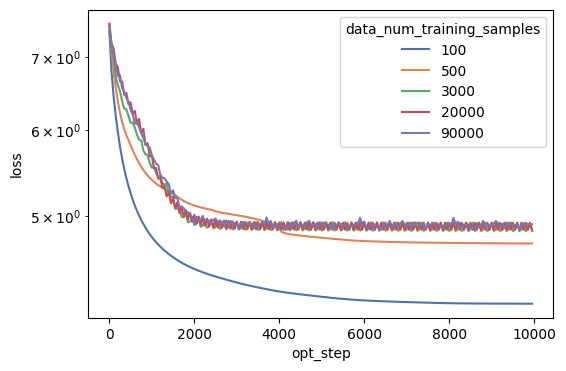

In [5]:
#@title Training visualization
fig, axarray = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    full_train_df.query('current_sequence == "minibatch_0"'),
    x='opt_step',
    y='loss',
    hue='data_num_training_samples',
    palette='deep',
    ax = axarray
)
plt.yscale('log')
plt.show()

/var/folders/71/km2vjr3d66b569t17hqrzqpc0000gn/T/ipykernel_47893/1277941473.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


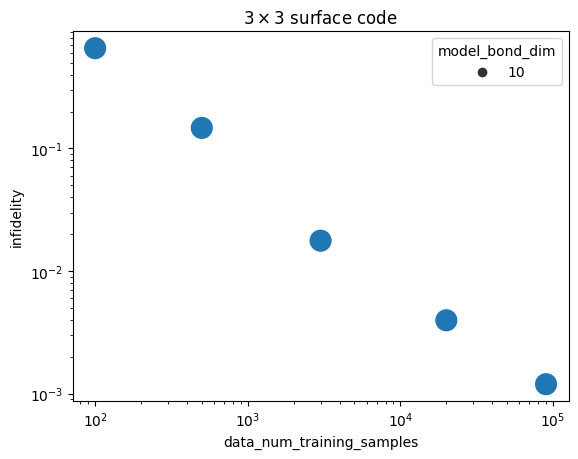

In [6]:
#@title Eval visualization

sns.scatterplot(
    full_eval_df.query('current_sequence == "lbfgs_1"'),
    x='data_num_training_samples',
    y='infidelity',
    style='model_bond_dim',
    s=300,
    palette='vlag',
)
plt.xscale('log')
plt.yscale('log')
plt.title(r'$3 \times 3$ surface code')
plt.show()